# End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using Tensorflow 2.0 and Tensorflow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

## 2. Data

The data we're using is from Kaggle's dog breed

https://www.kaggle.com/c/dog-breed-identification

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image

www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

## 4. Features

* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning
* The dataset comprises 120 breeds of dogs (this means there are 120 different classes)
* There are around 10,000+ images in the training set (these images have labels)
* There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them)

In [117]:
# Import neccessary tools
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from IPython.display import Image
import os

In [118]:
print("TF Version: ", tf.__version__)
print("TF Hub Version: ", hub.__version__)

TF Version:  2.19.1
TF Hub Version:  0.16.1


In [119]:
# Check for gpu availability
print("GPU", "available (YES)" if tf.config.list_physical_devices("GPU") else "(NO)")

GPU (NO)


### Getting our data ready (turning to Tensors)

Will all machine learning models, our data has to be in numerical format. So that's we'll be doing first. Turning our images to Tensors (numerical representation).

Let's start by accessing our data and checking out the labels.

In [4]:
# Checkout the labels or our data
labels_csv = pd.read_csv("../../data/dog-datasets/labels.csv")

In [5]:
labels_csv.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126

In [6]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

<Axes: xlabel='breed'>

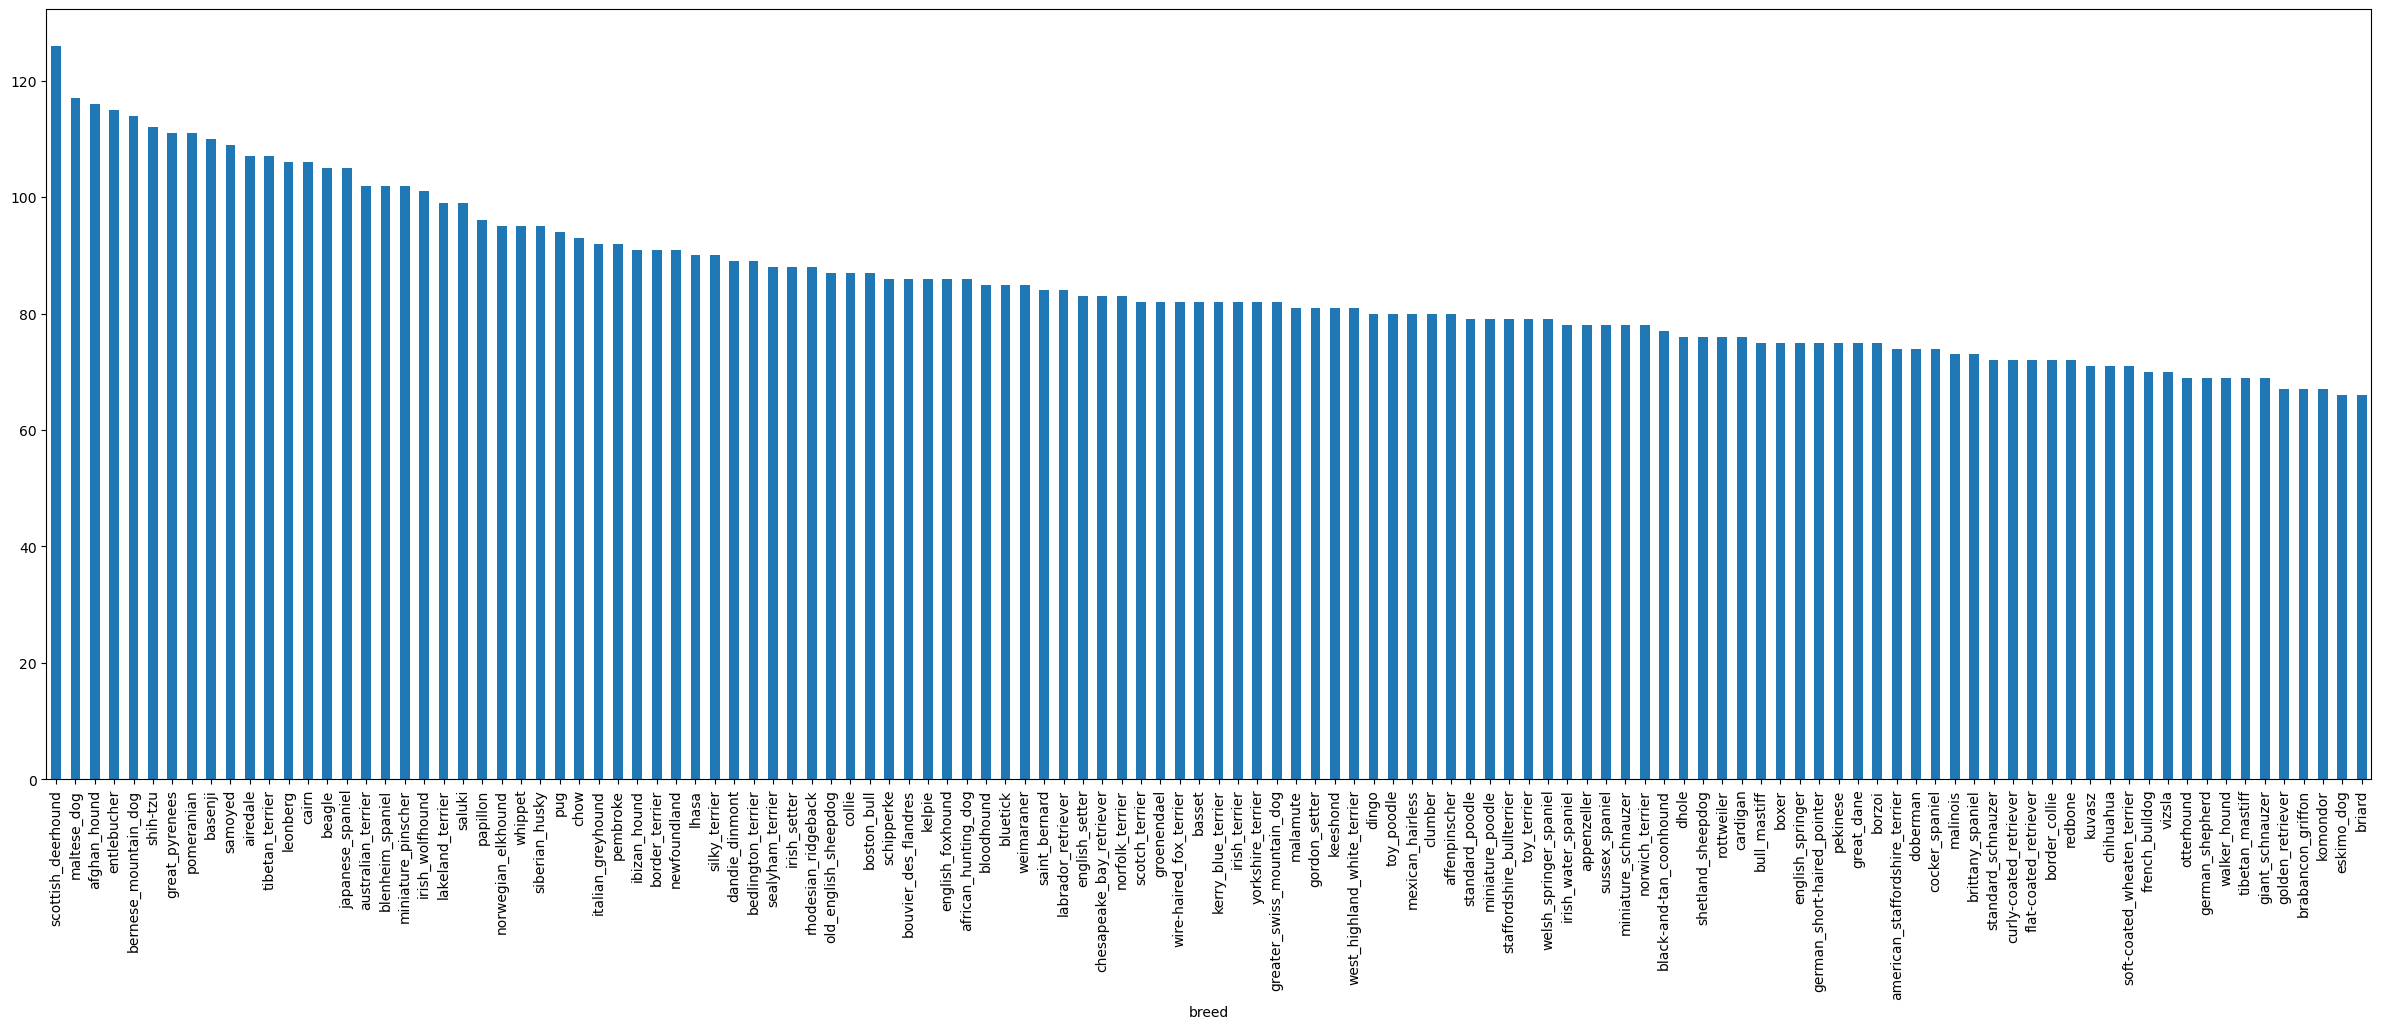

In [7]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(30, 10))

In [8]:
labels_csv["breed"].value_counts().median()

82.0

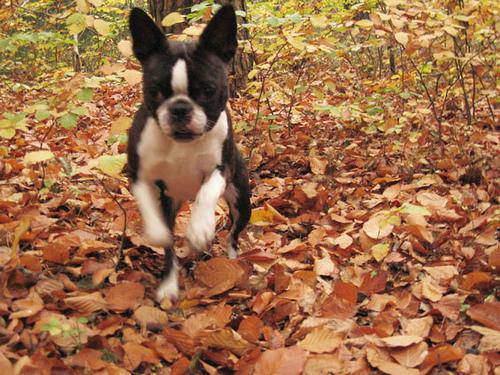

In [9]:
# Let's view an image
Image("../../data/dog-datasets/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

### Getting images and their labels

Let's get a list of all of our image file pathnames

In [10]:
# Create pathnames from image ID's
filenames = ["../../data/dog-datasets/train/" + image + ".jpg" for image in labels_csv["id"]]

# Check the first 10 and count the total id's
filenames[:10], len(filenames)

(['../../data/dog-datasets/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
  '../../data/dog-datasets/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
  '../../data/dog-datasets/train/001cdf01b096e06d78e9e5112d419397.jpg',
  '../../data/dog-datasets/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
  '../../data/dog-datasets/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
  '../../data/dog-datasets/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
  '../../data/dog-datasets/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
  '../../data/dog-datasets/train/002a283a315af96eaea0e28e7163b21b.jpg',
  '../../data/dog-datasets/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
  '../../data/dog-datasets/train/0042188c895a2f14ef64a918ed9c7b64.jpg'],
 10222)

In [11]:
# Check whether number of filenames matches number of actual image files
if len(os.listdir("../../data/dog-datasets/train")) == len(filenames):
    print("Filenames match actual amount of files! Proceed")
else:
    print("Filename do not match amount of files, check the target directory")

Filenames match actual amount of files! Proceed


In [12]:
print("Count number of files under training folder: ", len(os.listdir("../../data/dog-datasets/train")))

Count number of files under training folder:  10222


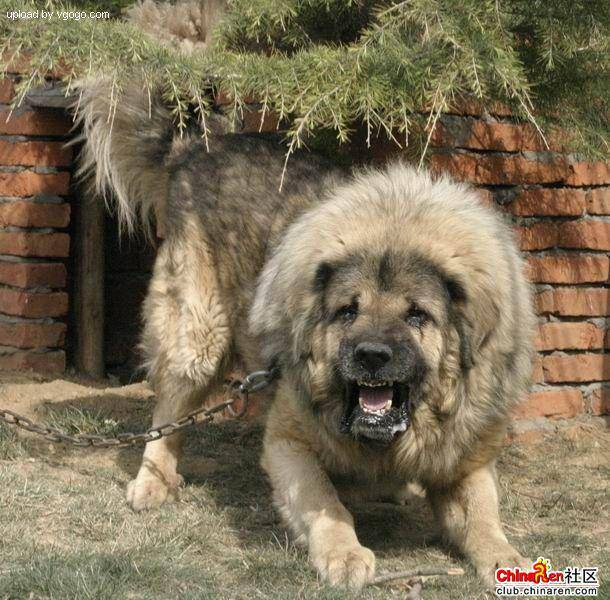

In [13]:
# Check if we can load the image
Image(filenames[9000])

In [14]:
# Print the breed of the above image
labels_csv["breed"][9000]

'tibetan_mastiff'

### Since we've now got our training image filepaths in a list, let's prepare our labels

In [15]:
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels_csv["breed"])

In [16]:
labels[:10], len(labels)

(array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
        'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
        'scottish_deerhound'], dtype=object),
 10222)

In [17]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
    print("Number of labels matches number of filenames")
else:
    print("Number of labels does not match number of filenames, check data directory")

Number of labels matches number of filenames


In [18]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds, len(unique_breeds)

(array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
        'american_staffordshire_terrier', 'appenzeller',
        'australian_terrier', 'basenji', 'basset', 'beagle',
        'bedlington_terrier', 'bernese_mountain_dog',
        'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
        'bluetick', 'border_collie', 'border_terrier', 'borzoi',
        'boston_bull', 'bouvier_des_flandres', 'boxer',
        'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
        'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
        'chow', 'clumber', 'cocker_spaniel', 'collie',
        'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
        'doberman', 'english_foxhound', 'english_setter',
        'english_springer', 'entlebucher', 'eskimo_dog',
        'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
        'german_short-haired_pointer', 'giant_schnauzer',
        'golden_retriever', 'gordon_setter', 'gre

In [19]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [20]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [21]:
len(boolean_labels)

10222

In [22]:
# Example: Turning boolean array into integers
print(labels[0])
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set
Since the dataset from kaggle doesn't com with a validation set, we're going to create our own

In [23]:
# Setup x & y variables
x = filenames
y = boolean_labels

We're going to start off experimenting with ~1000 images and increase as needed

In [24]:
# Set number of images to use for experiment
NUM_IMAGES = 1000

In [25]:
# Let's split our data into train and validation sets
# Split them into training and validation of total size NUM_IMAGES
x_train, x_val, y_train, y_val = train_test_split(x[:NUM_IMAGES],
                                                   y[:NUM_IMAGES],
                                                   test_size=0.2,
                                                   random_state=42)

In [26]:
len(x_train), len(x_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [27]:
# Let's have a geez at the training data
x_train[:5], y_train[:5]

(['../../data/dog-datasets/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '../../data/dog-datasets/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  '../../data/dog-datasets/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  '../../data/dog-datasets/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  '../../data/dog-datasets/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False

### Preprocessing Images (turning images to Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use Tensorflow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpeg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1)
5. Resize the `image ` to be a shape of (224, 224)
6. Return the modified image

Before we do, le'ts see what importing an image looks like

In [28]:
# Convert image to Numpy array
from matplotlib.pyplot import imread

image = imread(filenames[42])
image.shape

(257, 350, 3)

In [29]:
# Turnn image to a Tensor
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

In [30]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
    """
    Takes an image file path and turns the image into a Tensor
    """

    # Read in an image file
    image = tf.io.read_file(image_path)
    # Turn the jpeg into numerical Tensor with 3 color channels (Red, Blue, Green)
    image = tf.image.decode_jpeg(image, channels=3)
    # Convert the color channel values from 0-255 to 0-1 values (normalize)
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to our desired value (224, 224)
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

    return image

### Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory

So that's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size if need be)

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: `(image, label)`

In [31]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
    """
     Takes an image file path name and associated label, 
     processes the image and returns a tuple of (image, label)
    """

    image = process_image(image_path)
    return image, label

Now we've got a way to turn our data into tumples of Tensors in the form: `(image, label)`, let's make a function to turn all of our data (x & y) into batches

In [32]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Create batches of data out of image (x) and label (y) pairs
    Shuffles the data if it's training data but doesn't if it's validation data
    Also accepts test data as input (no labels)
    """

    # If the data is a test dataset, we probably don't have labels
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths (no labels)
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch

    # If the data is a valid dataset, we don't need to shuffle it
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                                  tf.constant(y))) # labels
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch

    else:
        print("Creating training data batches...")
        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                                  tf.constant(y)))
        # Shuffling pathnames and labels before mapping image processor functions is faster than shuffling images
        data = data.shuffle(buffer_size=len(x))
        # Create (image, label) tuples (this also turns the image path into a preprocessed image)
        data = data.map(get_image_label)
        # Turn the training data into batches
        data_batch = data.batch(BATCH_SIZE)
        return data_batch

In [33]:
# Create training and validation data batches
train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_val, y_val)

Creating training data batches...
Creating training data batches...


In [34]:
# Check out the different attributes of or data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

### Visualizing Data Batches

Our data is now in batches, however, the can be a little hard to understand/comprehend, let's visualize them

In [35]:
import matplotlib.pylab as plt

In [36]:
# Create a function for viewing images in a data batch
def show_25_images(images, labels):
    """
    Displays a plot of 25 images and their labels from a data batch
    """
    # Setup the figure
    plt.figure(figsize=(10, 10))
    
    # Loop through 25 (for displaing 25 images)
    for i in range(25):
        # Create subplot (5 rows, 5 columns)
        ax = plt.subplot(5, 5, i + 1)
        # Add the image label as the title
        plt.title(unique_breeds[labels[i].argmax()])
        # Turn the grid lines off
        plt.axis("off")
        # Diplay an image
        plt.imshow(images[i])

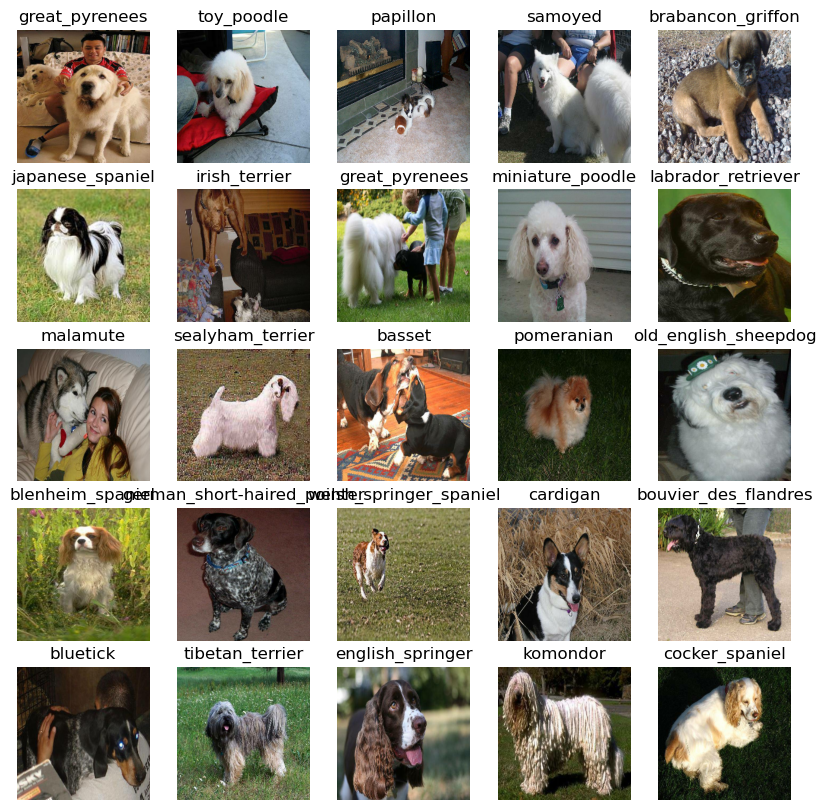

In [37]:
# Now let's visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

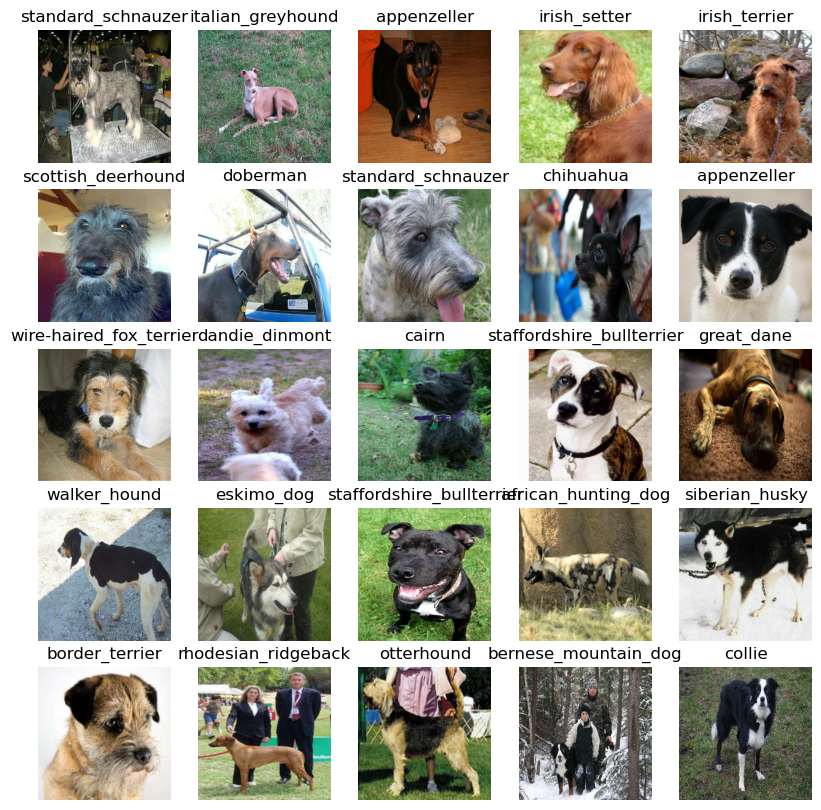

In [38]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

### Building a model

Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the form of Tensors) to our model
* The output shape (image labels, in the form of Tensors) of our model
* The URL of the model we want to use from Tensorflow Hub - https://www.kaggle.com/models/google/mobilenet-v2/tensorFlow2/130-224-classification2

In [39]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from Tensorflow Hub
MODEL_URL = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2"

Now we've got our inputs, outputs and model ready to go
Let's put them together into a Keras deep learning model

Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've chose as parameters
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that)
* Compiles the model (says it should be evaluated and improved)
* Builds the model (tells the model the input shape it'll be getting)
* Returns the model

All of these steps can be found here: https://www.tensorflow.org/guide/keras

In [40]:
import tf_keras

# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print("Building model with:", model_url)

    # Setup the model layers
    model = tf_keras.Sequential([
        hub.KerasLayer(model_url), # Layer 1 (input layer)
        tf_keras.layers.Dense(units=output_shape,
                             activation="softmax") # Layer 2 (output layer)
    ])

    # Compile the model
    model.compile(
        loss=tf_keras.losses.CategoricalCrossentropy(),
        optimizer=tf_keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    # Build the model
    model.build(input_shape)

    return model

In [41]:
model = create_model()
model.summary()

Building model with: https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


### Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from traning for too long

### TensorBoard Callback

To setup a TensorBoard ballback, we need to do 3 things:
1. Load the TensorBoard notebook extension
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function
3. Visualize our models training logs with the `%tensorboard` magic function (we'll do this after model training)

In [42]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [43]:
import datetime

# Create a function to build a Tensorboard callback
def create_tensorboard_callback():
    # Create a log directory for storing Tensorboard logs
    logdir = os.path.join("../../logs",
                         # Make it so logs get tracked whenever we run an experiment
                         datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tf_keras.callbacks.TensorBoard(logdir)

## Early Stopping Callback

Early stopping helps stop our model from overfitting by stopping traning if a certain evaluation metric stops improving

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [44]:
# Create early stopping callback
early_stopping = tf_keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                 patience=3)

### Traning a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working

In [45]:
NUM_EPOCHS = 100

Let's create a function which trains a model

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the trainig data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callback we'd like to use
* Return the model

In [46]:
# Build a function to train and return a trained model
def train_model():
    """
    Trains a given model and returns the trained version    
    """

    # Create a model
    model = create_model()

    # Create new TensorBoard session everytime we train a model
    tensorboard = create_tensorboard_callback()

    # Fit the model to the data passing it the callbacks we created
    model.fit(x=train_data,
             epochs=NUM_EPOCHS,
             validation_data=val_data,
             validation_freq=1,
             callbacks=[tensorboard, early_stopping])

    # Return the fitted model
    return model

In [47]:
# Fit the model to the data
model = train_model()

Building model with: https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2
Epoch 1/100
25/25 [==============================] - 23s 695ms/step - loss: 4.5328 - accuracy: 0.0925 - val_loss: 3.2443 - val_accuracy: 0.2500
Epoch 2/100
25/25 [==============================] - 17s 668ms/step - loss: 1.5879 - accuracy: 0.7250 - val_loss: 2.0659 - val_accuracy: 0.5200
Epoch 3/100
25/25 [==============================] - 16s 625ms/step - loss: 0.5508 - accuracy: 0.9350 - val_loss: 1.6256 - val_accuracy: 0.6000
Epoch 4/100
25/25 [==============================] - 16s 647ms/step - loss: 0.2479 - accuracy: 0.9912 - val_loss: 1.4760 - val_accuracy: 0.6200
Epoch 5/100
25/25 [==============================] - 15s 601ms/step - loss: 0.1443 - accuracy: 0.9987 - val_loss: 1.4025 - val_accuracy: 0.6650
Epoch 6/100
25/25 [==============================] - 14s 570ms/step - loss: 0.0986 - accuracy: 1.0000 - val_loss: 1.3526 - val_accuracy: 0.6450
Epoch 7/100
25/25 [=========

**Question:** It looks like our model is overfitting because it's performing far better on the training dataset than the validation dataset, what are some ways to prevent model overfitting in deep leanring neural networks?


**Note:** Overfitting to begin with is a good thing! It means our model is learning!

### Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualize its contents

In [48]:
%tensorboard --logdir ../../logs

## Making and evaluating predictions using a trained model

In [49]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 3s 366ms/step


array([[3.57732326e-01, 3.96386720e-04, 2.67037813e-05, ...,
        2.53879069e-03, 4.45669983e-04, 9.07422230e-02],
       [2.81698187e-04, 1.99257891e-04, 9.41748731e-03, ...,
        7.14403694e-04, 6.65909238e-06, 1.28720398e-03],
       [1.08683598e-03, 9.88597676e-05, 3.61366656e-05, ...,
        1.11663234e-04, 1.38330925e-05, 1.18911837e-03],
       ...,
       [4.72702930e-04, 2.76345003e-04, 4.25023085e-04, ...,
        6.43961102e-05, 2.46028719e-03, 2.21770839e-04],
       [1.70251024e-05, 1.00100879e-05, 7.25339996e-05, ...,
        6.59504367e-05, 5.20808913e-04, 7.22625191e-05],
       [2.40670238e-03, 1.45810191e-05, 1.22249301e-04, ...,
        8.35744650e-05, 4.14901238e-04, 2.78534810e-03]], dtype=float32)

In [50]:
np.sum(predictions[0]) # total prediction probability

0.9999999

In [51]:
# 1st prediction
index = 0
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

Max value (probability of prediction): 0.3577323257923126
Sum: 0.9999998807907104
Max index: 0
Predicted label: affenpinscher


Having the above functionality is great but we want to be able to do it at scale

And it would be even better if we could see the image the prediction is being made on

**Note:** Prediction probabilities are also known as confidence levels

In [52]:
# Turn prediction probabilities into the respective label (easier to understand)
def get_pred_label(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label
    """

    return unique_breeds[np.argmax(prediction_probabilities)]

In [53]:
# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'affenpinscher'

Now since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels)

In [69]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
    """
    Takes a batched dataset of (image, label) Tensors and returns separate arrays
    of images and labels
    """

    images_ = []
    labels_ = []

    # Loop through unbatched data
    for image, label in data.unbatch().as_numpy_iterator():
        images_.append(image)
        labels_.append(unique_breeds[np.argmax(label)])

    return images_, labels_

In [70]:
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0], get_pred_label(val_labels[0])

(array([[[0.8931196 , 0.9637078 , 0.9793941 ],
         [0.9052872 , 0.97587544, 0.9915617 ],
         [0.91351664, 0.9841049 , 0.9997911 ],
         ...,
         [0.03575872, 0.09458225, 0.11725146],
         [0.17377372, 0.26064348, 0.31792656],
         [0.3100761 , 0.40027216, 0.47086042]],
 
        [[0.89653367, 0.9671219 , 0.9828082 ],
         [0.9086201 , 0.97920835, 0.9948946 ],
         [0.9137658 , 0.984354  , 1.        ],
         ...,
         [0.02780648, 0.09439264, 0.12585273],
         [0.09559324, 0.1824259 , 0.23982033],
         [0.28380227, 0.37399837, 0.4445866 ]],
 
        [[0.899221  , 0.96980923, 0.9854955 ],
         [0.9114882 , 0.9820764 , 0.9977626 ],
         [0.91754794, 0.9881362 , 1.        ],
         ...,
         [0.17922203, 0.24630587, 0.2908962 ],
         [0.10636091, 0.1899044 , 0.25716633],
         [0.22936344, 0.3195595 , 0.39014778]],
 
        ...,
 
        [[0.1628763 , 0.22169983, 0.24130768],
         [0.17792347, 0.23674701, 0.25635

Now we've got ways to get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some function to make these all a bit more visualize

We'll create a function which:
* Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer
* Convert the prediction probabilities to a predicted label
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot

In [82]:
def plot_pred(prediction_probabilities, labels, images, n=1):
    """
    View the prediction, ground truth and image for sample n
    """

    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

    # Get the pred label
    pred_label = get_pred_label(pred_prob)

    # Plot images & remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    # Change the color of the title depending on if the prediction is right or wrong
    if pred_label == true_label:
        color = "green"
    else:
        color = "red"

    # Change plot title to be predicted, probability of prediction and truth label
    plt.title("{} {:2.0f}% {}".format(pred_label,
                                     np.max(pred_prob) * 100,
                                     true_label),
             color=color)

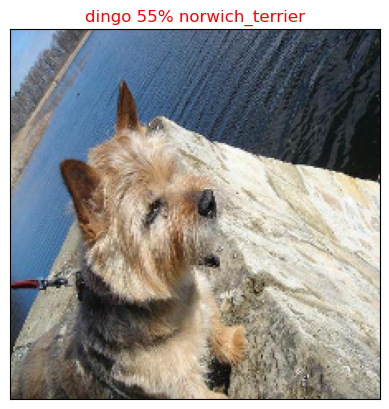

In [100]:
plot_pred(prediction_probabilities=predictions,
         labels=val_labels,
         images=val_images,
         n=5)

Now we've got on function to visualize our models top predictions, let's make another to view our models top 10 predictions

This function will:
* Take an input of prediction probabilities array and a ground truth array and an integers
* Find the prediction using `get_pred_label()`
* Find the top 10:
  * Prediction probabilities indexes
  * Prediction probabilities values
  * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green

In [94]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
    """
    Plus the top 10 highest prediction confidences along with truth label for sample n
    """

    pred_prob, true_label = prediction_probabilities[n], labels[n]

    # Get the predicted label
    pred_label = get_pred_label(pred_prob)

    # Find the top 10 prediction confidence indexes
    top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
    # Find the top 10 prediction confidence values
    top_10_pred_values = pred_prob[top_10_pred_indexes]
    # Find the top 10 prediction labels
    top_10_pred_labels = unique_breeds[top_10_pred_indexes]

    # Setup plot
    top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                      top_10_pred_values,
                      color="grey")
    plt.xticks(np.arange(len(top_10_pred_labels)),
              labels=top_10_pred_labels,
              rotation="vertical")

    # Change color of true label
    if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
    else:
        pass

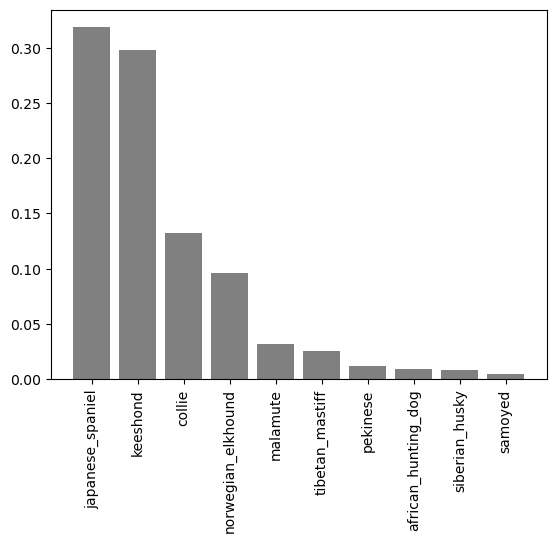

In [95]:
plot_pred_conf(prediction_probabilities=predictions,
              labels=val_labels,
              n=1)

Now we've got some funciton to help us visualize our predictions and model, let's check out a few

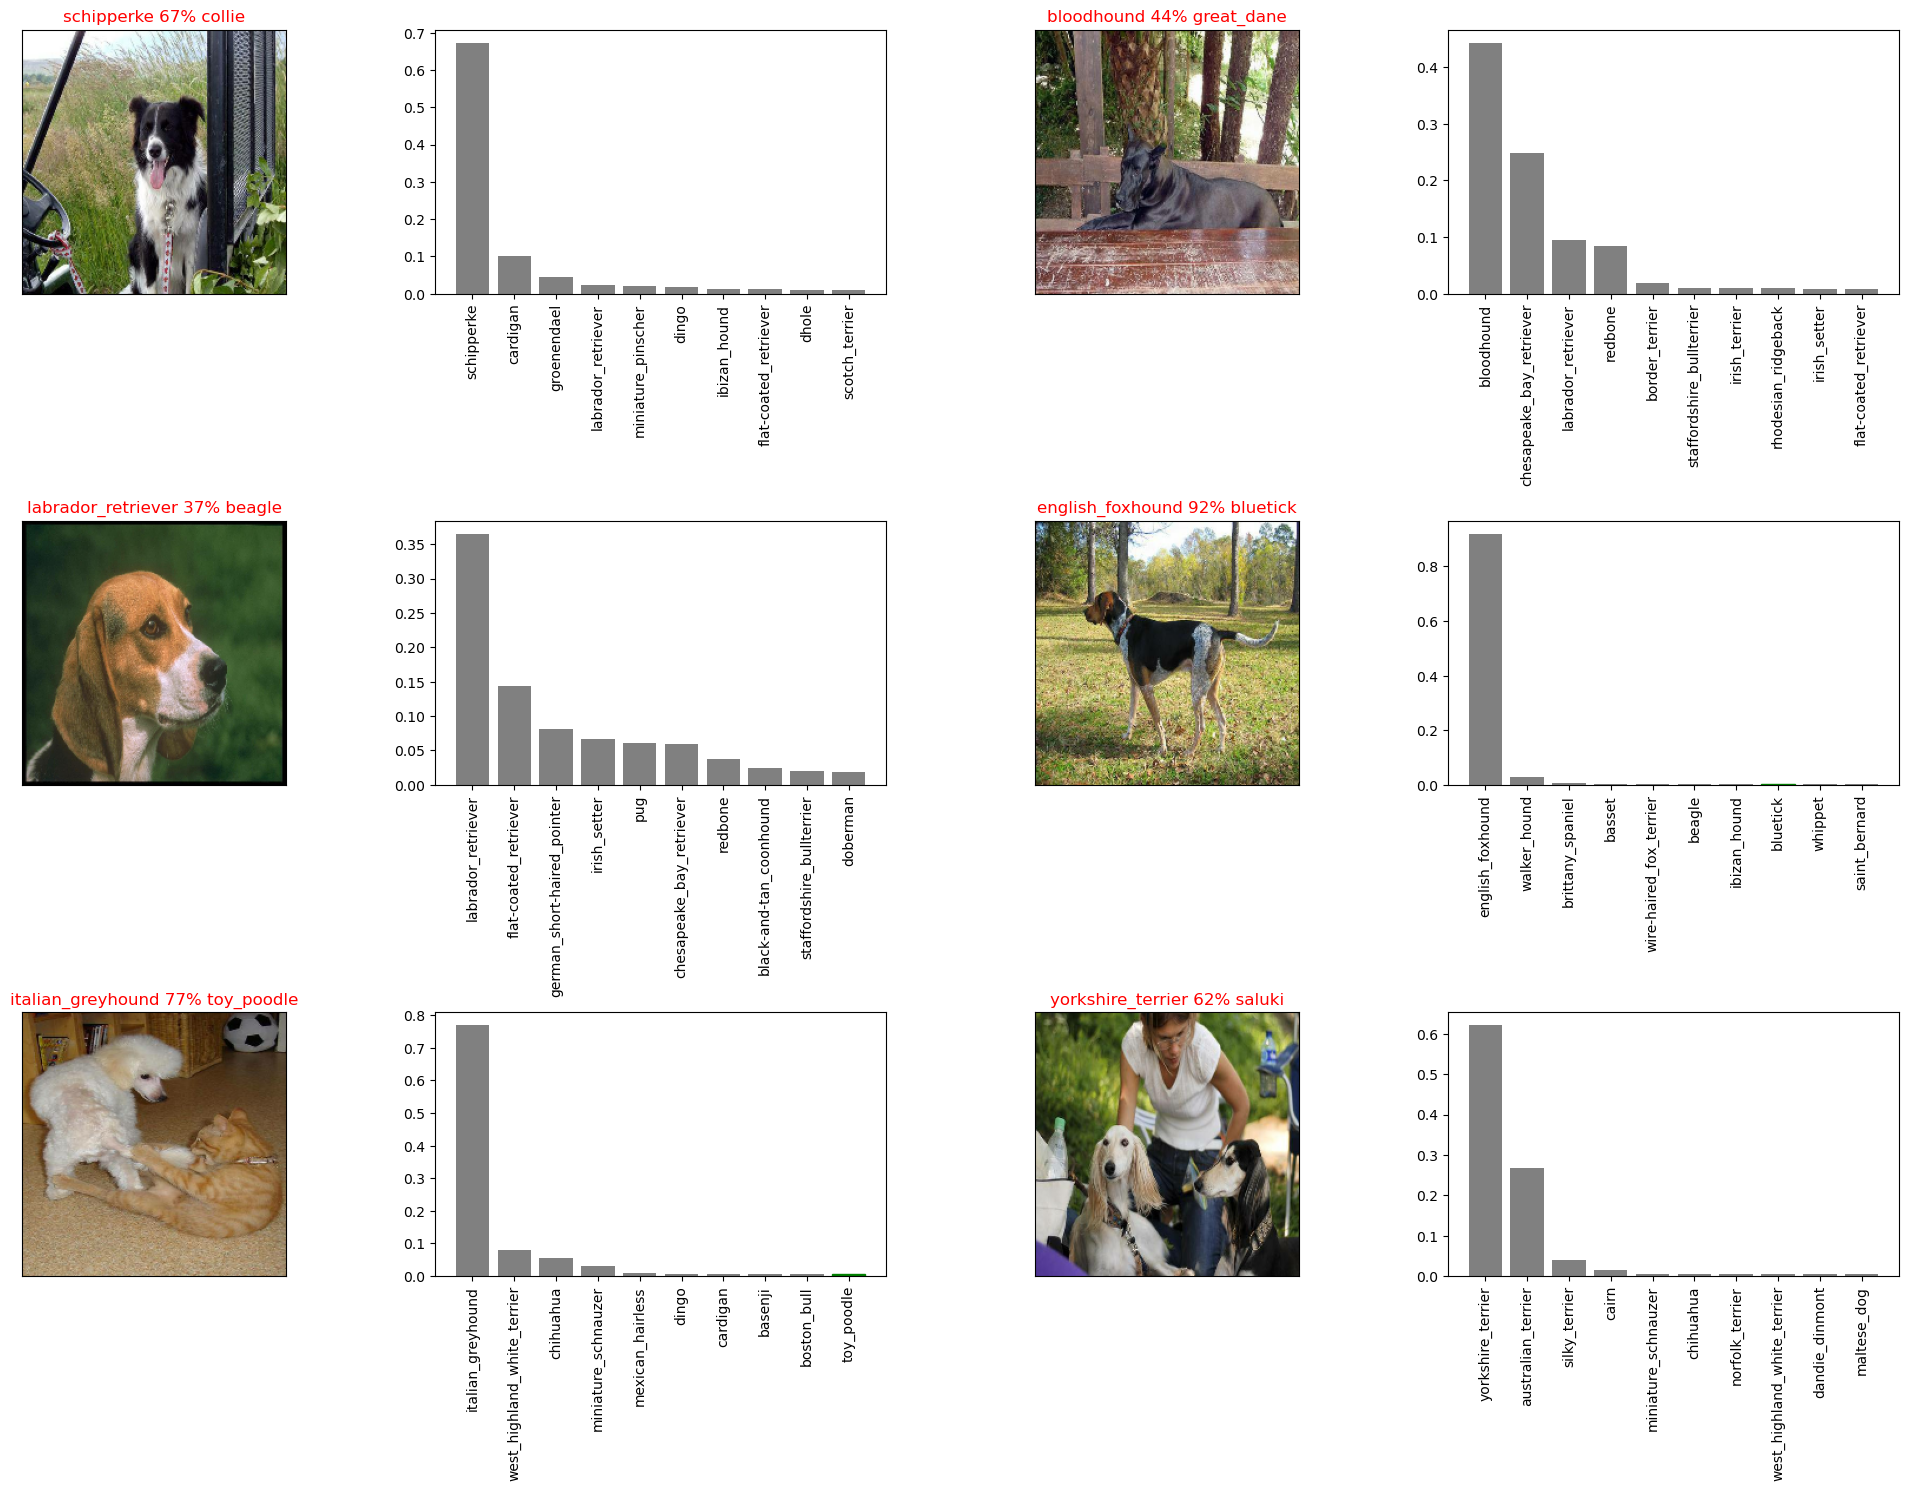

In [105]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols

plt.figure(figsize=(10 * num_cols, 5 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_pred(prediction_probabilities=predictions,
             labels=val_labels,
             images=val_images,
             n = i + i_multiplier)

    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_pred_conf(prediction_probabilities=predictions,
                  labels=val_labels,
                  n = i + i_multiplier)

plt.tight_layout(h_pad=1)
plt.show()

**Challenge:** How would you create a confusion matrix with our models predictions and true labels?

### Saving and reloading a trained model

In [110]:
# Create a function to save a model
def save_model(model, suffix=None):
    """
    Saves a given model in a models directory and appends a suffix (string)
    """

    # Create a model directory pathname with current time
    modeldir = os.path.join("../../models",
                           datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
    model_path = modeldir + "_" + suffix + "_" + ".keras" # save format of model
    print(f"Saving model to: {model_path}...")
    model.save(model_path)
    return model_path

In [111]:
# Create a function to load a trained model
def load_model(model_path):
    """
    Loads a saved model from a specified path
    """

    print(f"Loading saved model from: {model_path}")
    model = tf_keras.models.load_model(model_path,
                                      custom_objects={"KerasLayer": hub.KerasLayer})

    return model

Now we've got functions to save and load a trained model, let's make sure they work

In [113]:
# Save our model trained on 1000 images
saved_model_path = save_model(model, suffix="100-images-mobilenetv2-Adam")

Saving model to: ../../models/20250825-15261756106785_100-images-mobilenetv2-Adam_.keras...


In [114]:
# Load a trained model
loaded_1000_image_model = load_model(saved_model_path)

Loading saved model from: ../../models/20250825-15261756106785_100-images-mobilenetv2-Adam_.keras


In [115]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 3s 347ms/step - loss: 1.3094 - accuracy: 0.6650


[1.309367060661316, 0.6650000214576721]

In [116]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 3s 340ms/step - loss: 1.3094 - accuracy: 0.6650


[1.3093671798706055, 0.6650000214576721]

## Traning a big dog model (on the full data)

In [120]:
full_data = create_data_batches(x, y)

Creating training data batches...


In [121]:
full_model = create_model()

Building model with: https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2


In [123]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf_keras.callbacks.EarlyStopping(monitor="accuracy",
                                                            patience=3)

**Note:** Running the cell below will take a little while (maybe up to 30 minutes for the first epock) because the GPU we're using in the runtime has to load all of the images into memory

In [124]:
# Fit the full model to the full data
full_model.fit(x=full_data,
              epochs=NUM_EPOCHS,
              callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 145s 444ms/step - loss: 1.3711 - accuracy: 0.6658
Epoch 2/100
320/320 [==============================] - 143s 448ms/step - loss: 0.4018 - accuracy: 0.8781
Epoch 3/100
320/320 [==============================] - 144s 450ms/step - loss: 0.2378 - accuracy: 0.9354
Epoch 4/100
320/320 [==============================] - 145s 454ms/step - loss: 0.1560 - accuracy: 0.9617
Epoch 5/100
320/320 [==============================] - 149s 464ms/step - loss: 0.1082 - accuracy: 0.9777
Epoch 6/100
320/320 [==============================] - 150s 468ms/step - loss: 0.0786 - accuracy: 0.9861
Epoch 7/100
320/320 [==============================] - 151s 473ms/step - loss: 0.0582 - accuracy: 0.9916
Epoch 8/100
320/320 [==============================] - 153s 477ms/step - loss: 0.0462 - accuracy: 0.9945
Epoch 9/100
320/320 [==============================] - 153s 478ms/step - loss: 0.0384 - accuracy: 0.9952
Epoch 10/100
320/320 [==============================] -

In [125]:
saved_full_model_path = save_model(full_model, suffix="full-images-mobilenetv2-Adam")

Saving model to: ../../models/20250825-16221756110145_full-images-mobilenetv2-Adam_.keras...


'../../models/20250825-16221756110145_full-images-mobilenetv2-Adam_.keras'

In [126]:
loaded_full_model = load_model("../../models/20250825-16221756110145_full-images-mobilenetv2-Adam_.keras")

Loading saved model from: ../../models/20250825-16221756110145_full-images-mobilenetv2-Adam_.keras


### Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format

Luckily we created `create_data_batches()` earlier which can take a list of filenames as input and conver them into Tensor batches

To make predictions on the test data, we'll:
* Get the test image filenames
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since the test data doesn't have labels)
* Make a predictions array by passing the test batches to the `predict()` method called on our model

In [127]:
# Load test image filenames
test_path = "../../data/dog-datasets/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:3]

['../../data/dog-datasets/test/48d7404637dc82b693e47e22afaf1ddf.jpg',
 '../../data/dog-datasets/test/e57820007fcc2a07a5230177965a0f59.jpg',
 '../../data/dog-datasets/test/74d0958335f471545048b074781c5228.jpg']

In [211]:
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


**Note:** Calling `predict()` on our full model and passing it the test data batch will take a long time to run (about an ~1hr)

In [212]:
# Make a predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data, verbose=1)

324/324 [==============================] - 153s 474ms/step


In [213]:
# Save predictions (Numpy array) to csv file (for access later)
np.savetxt("../../data/dog-datasets/predictions/preds_array.csv", test_predictions, delimiter=",")

In [214]:
# Load predictions (Numpy array) from csv file
test_predictions = np.loadtxt("../../data/dog-datasets/predictions/preds_array.csv", delimiter=",")

### Preparing test dataset predictions for Kaggle

Looking at the Kaggle sample submission, we find that it wants our models prediction propability outputs in a DataFrame with an ID and a column for each different dog breed

To get the data in this format, we'll:
* Create a pandas DataFrame with an ID column as well as a column for each dog breed
* Add data to the ID column by extracting the test image ID's from their filepaths
* Add data (the prediction propabilities) to each of the dog breed columns
* Export the DataFrame as a CSV to submit it to Kaggle

In [215]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [217]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path) for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [218]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

id  affenpinscher  afghan_hound  \
0  (48d7404637dc82b693e47e22afaf1ddf, .jpg)   4.639207e-07  1.035904e-05   
1  (e57820007fcc2a07a5230177965a0f59, .jpg)   5.275857e-12  1.188250e-11   
2  (74d0958335f471545048b074781c5228, .jpg)   3.571682e-12  4.079163e-14   
3  (c8f7a7f9999d3e2da83529c0185b9e73, .jpg)   4.310473e-05  6.251040e-09   
4  (d073c9cffe0cf5d1d9d0862033289f16, .jpg)   2.948468e-10  5.304277e-12   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         1.586410e-11  2.218730e-10                    1.062551e-08   
1         9.103066e-14  7.498777e-12                    1.487324e-11   
2         1.971216e-10  9.853696e-13                    3.047394e-14   
3         2.485240e-09  4.228944e-07                    4.133501e-06   
4         2.356221e-11  5.293458e-10                    1.542909e-11   

    appenzeller  australian_terrier       basenji        basset  ...  \
0  4.398518e-12        1.078363e-07  1.491031e-08  2.092221e-11  ...   
1  2.715169e-11        3.386076e-11  1.520982e-10  1.579366e-09  ...   
2  4.565644e-09        6.557442e-10  9.686494e-08  1.485958e-14  ...   
3  7.959390e-08        4.165918e-05  3.460914e-05  1.109646e-06  ...   
4  7.067110e-11        8.618515e-08  1.745644e-10  9.816025e-13  ...   

     toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0  2.449823e-07  1.158960e-10  2.230426e-12  1.463667e-08  2.801387e-09   
1  1.439519e-13  4.923343e-13  1.657950e-13  2.309100e-10  2.991468e-12   
2  7.988356e-09  9.999980e-01  1.584697e-12  2.594988e-13  3.505986e-13   
3  2.318379e-06  8.575818e-05  2.494887e-08  2.499303e-08  4.202968e-08   
4  5.220583e-10  3.064820e-08  6.989904e-08  1.865457e-11  2.340336e-13   

   welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0            3.076979e-10                 1.221448e-08  7.231372e-10   
1            9.999774e-01                 9.403103e-11  4.515317e-11   
2            3.163419e-11                 3.169259e-11  2.269935e-12   
3            2.599772e-04                 1.760852e-03  1.895214e-08   
4            1.014484e-10                 1.884558e-11  9.347087e-08   

   wire-haired_fox_terrier  yorkshire_terrier  
0             4.441920e-05       9.115825e-09  
1             6.970617e-12       4.483696e-13  
2             1.472721e-11       2.755278e-09  
3             1.452589e-04       9.133475e-01  
4             7.468515e-07       4.136839e-09  

[5 rows x 121 columns]

In [219]:
# Save our predictions dataframe to CSV for submission to Kaggle
preds_df.to_csv("../../data/dog-datasets/full_model_predictions_submission_mobilenetv2.csv", index=False)

### Making predictions on custom images

To make predictions on custom images, we'll:
* Get the filepaths of our own images
* Turn the filepaths into data batches using `create_data_batches()`. And since our custom images won't have labels, we set the `test_data` parameter to `True`
* Pass the custom image data batch to our mode's `predict()` method
* Convert the prediction output probabilities to predictions labels
* Compare the predicted labels to the custom images

In [242]:
# Get custom image filepaths
custom_path = "../../data/dog-datasets/dogs/"
custom_image_path = [custom_path + fname for fname in os.listdir(custom_path)]

In [243]:
# Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_path, test_data=True)
custom_data

Creating test data batches...


<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [244]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

1/1 [==============================] - 0s 99ms/step


In [245]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['doberman',
 'black-and-tan_coonhound',
 'german_shepherd',
 'miniature_poodle',
 'blenheim_spaniel']

In [247]:
# Get custom images (our unbatchify) function won't work since there aren't labels... maybe we could fix this later
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
    custom_images.append(image)

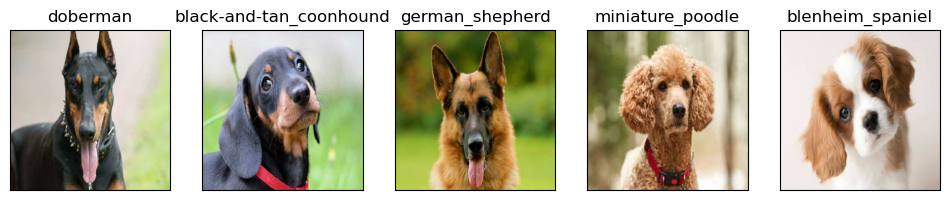

In [254]:
# check custom image predictions
plt.figure(figsize=(12, 10))
for i, image in enumerate(custom_images):
    plt.subplot(1, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title(custom_pred_labels[i])
    plt.imshow(image)